In [18]:
import numpy as np
from matplotlib import pyplot as plt, cm
import os, sys
sys.path.append('/scratch/valles/masclet_framework')
import masclet_framework as masclet
import g3read as g3
from cython_fortran_file import FortranFile as FF
import pickle, json

from sklearn.neighbors import NearestNeighbors
import findiff
from scipy.ndimage import gaussian_filter1d

from tqdm import tqdm
from numba import prange, jit, njit

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

from multiprocessing import Pool

import time

from scipy.spatial import KDTree
import pickle

## Snap writer 
Following Antonio Ragagnin's tutorial at https://github.com/aragagnin/g3read/blob/master/README.md#writing-a-new-snapshot-file-from-scratch

In [5]:
def write_snap(boxsize,xtest,ytest,ztest,vxtest,vytest,vztest,mtest,htest,
               filename,path=''):
    filepath=os.path.join(path,filename)
    with open(filepath, 'a') as f:
        pass

    npart=xtest.size
    
    postest=np.zeros((xtest.size,3))
    vtest=np.zeros((xtest.size,3))
    
    postest[:,0]=xtest
    postest[:,1]=ytest
    postest[:,2]=ztest
    vtest[:,0]=vxtest
    vtest[:,1]=vytest
    vtest[:,2]=vztest

    npart_array = np.array([npart,0,0,0,0,0])
    mass_table=[0.]*6

    redshift=0.
    time=1./(1+redshift)

    Omega0=0.31
    OmegaLambda=1.-Omega0
    HubbleParam=0.678
    num_files=1

    # GENERATE HEADER
    header = g3.GadgetHeader(npart_array, mass_table, time, redshift, boxsize, Omega0, OmegaLambda, HubbleParam, num_files=num_files)
    f = g3.GadgetWriteFile(filepath, npart_array, {}, header)
    f.write_header(f.header)

    # allocate blocks data
    f.add_file_block('POS ', npart*4*3, partlen=4*3)
    f.add_file_block('MASS', npart*4, partlen=4)
    f.add_file_block('HSML', npart*4, partlen=4)
    f.add_file_block('VEL ', npart*4*3, partlen=4*3)

    # write blocks data to disk
    f.write_block('POS ', -1, postest)
    f.write_block('MASS', -1, mtest)
    f.write_block('HSML', -1, htest)
    f.write_block('VEL ', -1, vtest)

## Some fancy particle configuration for the test

### What about a background with around gaussian blobs?

In [6]:
def generate_particle_configuration(npart_bkg, npart_blobs, nblobs, boxsize, Rblobs, exclude_blobs):
    npart_per_blob = int(npart_blobs/nblobs)

    xpart=[]
    ypart=[]
    zpart=[]

    xpart.append(np.random.rand(npart_bkg).astype('f4'))
    ypart.append(np.random.rand(npart_bkg).astype('f4'))
    zpart.append(np.random.rand(npart_bkg).astype('f4'))

    for iblob in tqdm(range(nblobs)):
        xb,yb,zb=np.random.rand(3)*(boxsize-2*exclude_blobs)+exclude_blobs
        #print(xb,yb,zb);
        xpart.append(xb+Rblobs*np.random.randn(npart_per_blob).astype('f4'))
        ypart.append(yb+Rblobs*np.random.randn(npart_per_blob).astype('f4'))
        zpart.append(zb+Rblobs*np.random.randn(npart_per_blob).astype('f4'))

    xpart=np.concatenate(xpart)
    ypart=np.concatenate(ypart)
    zpart=np.concatenate(zpart)
    
    mpart=np.ones(xpart.size, dtype='f4')
    #hsml=np.ones(xpart.size)*(boxsize/xpart.size)**(1/3)
    
    ## Compute hsml
    print('Smoothing lengths...')
    knn = NearestNeighbors(n_neighbors=58, n_jobs=20)
    npart=xpart.size
    X=np.zeros((npart,3), dtype='f4')
    X[:,0]=xpart
    X[:,1]=ypart
    X[:,2]=zpart
    print('Fitting knn...')
    knn.fit(X)
    print('Computing distances...')
    if npart > 2e7:
        print('Computing distances in chunks...')
        hsml = np.zeros(npart)
        for idivide in range(100):
            print('Chunk %d'%idivide)
            i1 = idivide*npart//100
            i2 = (idivide+1)*npart//100 if idivide<99 else npart
            res=knn.kneighbors(X=X[i1:i2,:], n_neighbors=58)
            hsml[i1:i2]=res[0][:,-1]
        if hsml.min() == 0:
            print('WARNING: hsml.min() == 0')
    else:
        res=knn.kneighbors(X=X[:,:], n_neighbors=58)
        hsml=res[0][:,-1]
        
    return xpart,ypart,zpart,mpart,hsml

Need to change things by hand:
 - Folder realization_1: 2e6 particles 
 - Folder realization_2: 16e6 particles, multiply by 8 the number of particles below 
 - Folder realization_3: 128e6 particles, multiply by 64 the number of particles below

In [36]:
npart_bkg = int(.5e6) #* 8 * 8
npart_blobs = int(1.5e6) #* 8 * 8
nblobs = 100

boxsize=1.
Rblobs=0.02
exclude_blobs=0.25

print('Density bkg is: {:.3e}'.format(npart_bkg/boxsize**3))
print('Density of blobs (1-sigma) is: {:.3e}'.format(0.198*npart_blobs/nblobs/(4*np.pi/3*Rblobs**3)))

filename='particles_2e6.dat'
filepath=os.path.join('test_data/particles/', filename)
if os.path.exists(filepath):
    print('Warning!!! The file already exists. Reading it')
    with open(filepath, 'rb') as f:
        res=pickle.load(f)
        xpart=res['xpart']
        ypart=res['ypart']
        zpart=res['zpart']
        mpart=res['mpart']
        hpart=res['hsml']
        
    print('File read!')
else:
    xpart,ypart,zpart,mpart,hpart=generate_particle_configuration(npart_bkg, npart_blobs, nblobs, boxsize, Rblobs, exclude_blobs)
    with open(filepath, 'wb') as f:
        pickle.dump({'xpart': xpart, 'ypart': ypart, 'zpart': zpart, 'mpart': mpart, 'hsml': hpart}, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    print('File written!')

Density bkg is: 5.000e+05
Density of blobs (1-sigma) is: 8.863e+07
Warning!!! The file already exists. Reading it
File read!


### Test 1: constant div field

In [17]:
# Define the velocity field

omega_0 = 1000.
vxpart=omega_0*(xpart-boxsize/2)
vypart=omega_0*(ypart-boxsize/2)
vzpart=omega_0*(zpart-boxsize/2)

write_snap(boxsize, xpart, ypart, zpart, vxpart, vypart, vzpart, mpart, hpart,
           filename='snap_000',path='test_data/Test 1/realization_1/snapdir_000')

In [20]:
# Compute the smoothed velocities (just once)

if False:    
    smooth_velocities={}
    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    @njit(fastmath=True)
    def kernelfunc(dist, ktype='W4'):
        w = dist.max()/2 
        dist /= w
        kern = np.zeros(dist.size)
        if ktype == 'W4':
            wh = dist<1
            kern[wh] = 1.0-1.5*dist[wh]**2*(1-0.5*dist[wh])
            wh = (dist>=1)*(dist<2)
            kern[wh] = 0.25*(2-dist[wh])**3 
        elif ktype == 'C4':
            wh = dist<2
            kern[wh] = (1. - .5*dist[wh])**6 * (35./12.*dist[wh]**2 + 3.*dist[wh] + 1.)
        elif ktype == 'C6':
            wh = dist<2
            kern[wh] = (1.-.5*dist[wh])**8 * (4.*dist[wh]**3 + 25./4.*dist[wh]**2 + 4.*dist[wh] + 1.)
        
        kern /= kern.sum()
        return kern


    for irel in [1,2]:
        smooth_velocities[irel] = {}

        if irel == 1:
            filename='particles_2e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            with open(filepath, 'rb') as f:
                res=pickle.load(f)
                xpart=res['xpart']
                ypart=res['ypart']
                zpart=res['zpart']
                mpart=res['mpart']
                hpart=res['hsml']

        if irel == 2:
            filename='particles_16e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            if os.path.exists(filepath):
                print('Warning!!! The file already exists. Reading it')
                with open(filepath, 'rb') as f:
                    res=pickle.load(f)
                    xpart=res['xpart']
                    ypart=res['ypart']
                    zpart=res['zpart']
                    mpart=res['mpart']
                    hpart=res['hsml']

        vxpart=omega_0*(xpart-boxsize/2)
        vypart=omega_0*(ypart-boxsize/2)
        vzpart=omega_0*(zpart-boxsize/2)


        tree = KDTree(np.array([xpart, ypart, zpart]).T)
        for ikernel,kernel in enumerate(kernels):
            smooth_velocities[irel][kernel]={}
            for ingh,ngh in enumerate(neighbours):
                print(irel, kernel, ngh)
                smooth_velocities[irel][kernel][ngh]={'vx': None, 'vy': None, 'vz': None}

                vx_smooth = np.zeros(xpart.size)
                vy_smooth = np.zeros(xpart.size)
                vz_smooth = np.zeros(xpart.size)

                for i in tqdm(range(xpart.size)):
                    dist, ind = tree.query([xpart[i], ypart[i], zpart[i]], k=ngh)
                    weights = kernelfunc(dist)
                    weights /= weights.sum()
                    vx_smooth[i] = (weights*vxpart[ind]).sum()
                    vy_smooth[i] = (weights*vypart[ind]).sum()
                    vz_smooth[i] = (weights*vzpart[ind]).sum()

                smooth_velocities[irel][kernel][ngh]['vx'] = vx_smooth.copy()
                smooth_velocities[irel][kernel][ngh]['vy'] = vy_smooth.copy()
                smooth_velocities[irel][kernel][ngh]['vz'] = vz_smooth.copy()

        del tree

    with open('test_data/Test 1/smooth_velocities.dat', 'wb') as f:
        pickle.dump(smooth_velocities, f)

#### Draw the particle distribution and the grid

In [40]:
results_path='test_data/Test 1/realization_1/kC6_ngh356_base128_ref5'

it=0

In [44]:
nx=128
nmax=nx
size=1.
masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

In [45]:
npatch,patchnx,patchny,patchnz,patchx,patchy,patchz,patchrx,patchry,patchrz,pare=\
    masclet.read_masclet.read_grids(it,path=results_path,parameters_path=results_path, read_general=False,
                                    read_dmpartnum=False)

In [46]:
div,rotx,roty,rotz,spot,vpotx,vpoty,vpotz,\
 vcompx,vcompy,vcompz,vrotx,vroty,vrotz=masclet.read_masclet.read_vortex(it,path=results_path,grids_path=results_path,parameters_path=results_path,
                                 are_divrot=True,are_potentials=True,is_header=True)

In [48]:
levels = masclet.tools.create_vector_levels(npatch)
levels_field = [l*np.ones((nx,ny,nz)) for l,nx,ny,nz in zip(levels,patchnx,patchny,patchnz)]

In [49]:
ulev, coords = masclet.tools.uniform_grid_zoom_interpolate(levels_field, [-boxsize/2,boxsize/2-boxsize/nmax/2,-boxsize/2,boxsize/2-boxsize/nmax/2,-boxsize/2,boxsize/2-boxsize/nmax/2],
    2, npatch, patchnx,patchny,patchnz,patchrx,patchry,patchrz,boxsize,nx, interpolate=False, return_coords=True)

In [50]:
idx1 = np.where(coords[0]>-boxsize/2)[0][0]
idx2 = np.where(coords[0]<boxsize/2)[0][-1]
print(idx1, idx2)
ulev = ulev[idx1:idx2+1, idx1:idx2+1, idx1:idx2+1]

0 511


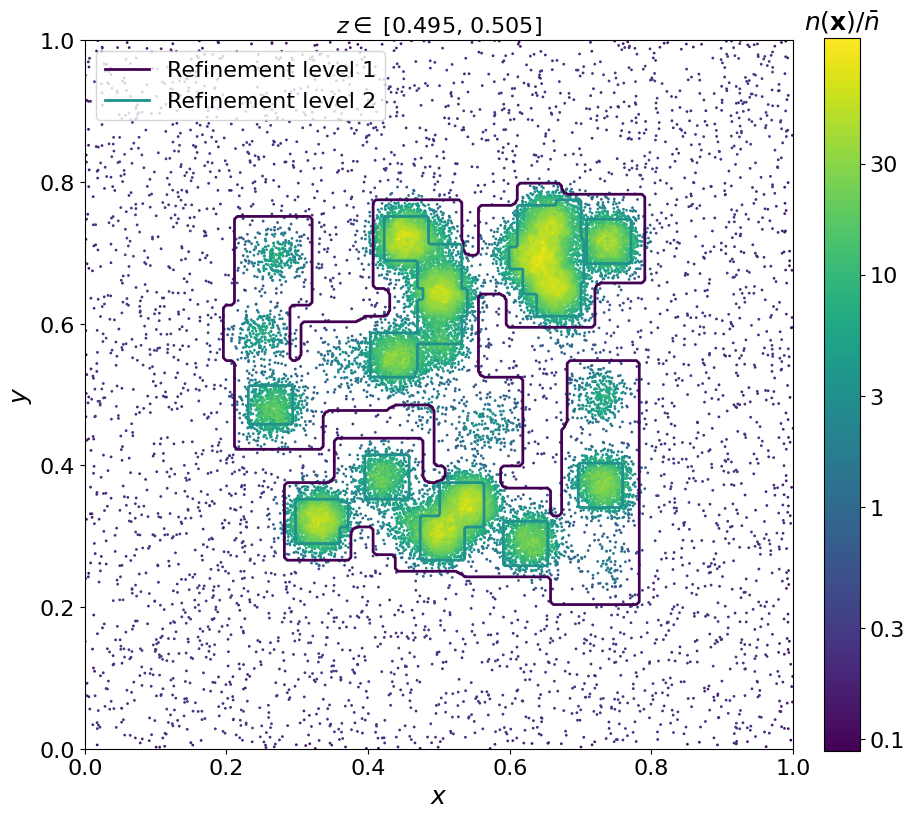

In [51]:
fontsize_big = 18
fontsize_small = 16

plt.figure(figsize=(10,10))
z1=0.495
width=0.01
z2=0.505
if width is not None:
    z2=z1+width
select=(z1 < zpart)*(zpart<z2)
plt.scatter(xpart[select],ypart[select], s=1, 
            c=np.log10(3*58/(4*np.pi)*hpart[select]**(-3) / (zpart.size/boxsize**3))
           # c=hpart[select])
           )
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.set_yticks(np.log10([.1,.3,1,3,10,30]))
cb.ax.set_yticklabels(['0.1','0.3','1','3','10','30'], fontsize=fontsize_small)
cb.ax.set_title(r'$n(\mathbf{x})/ \bar{n}$', fontsize=fontsize_big)
ax=plt.gca()
ax.set_aspect(1)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])

ax.tick_params(labelsize=fontsize_small)
ax.set_title('$z \in$ [{:.3f}, {:.3f}]'.format(z1,z2), fontsize=fontsize_small)
ax.set_xlabel('$x$', fontsize=fontsize_big)
ax.set_ylabel('$y$', fontsize=fontsize_big)

nxuni = ulev.shape[0]
xvec=np.linspace(0, boxsize, nxuni)
yvec=np.linspace(0, boxsize, nxuni)

k1 = int(z1*nxuni/boxsize)
k2 = int(z2*nxuni/boxsize)+1
km = int((k1+k2)/2)

### This is just a dummy thing to remove gaps in the contour bc of its interpolation...
#arr = ulev[:,:,km].copy()
arr = ulev[:,:,k1:k2].max(axis=2)
arr2 = arr.copy()
for i in range(2, nxuni-2):
    for j in range(2, nxuni-2):
        l = arr2[i,j]
        if l==1:
            count = int(arr2[i+1,j]>l) + int(arr2[i-1,j]>l) + int(arr2[i,j+1]>l) + int(arr2[i,j-1]>l)
            if count>=2:
                arr[i,j]=l+1
        elif l==0:
            # go two cells beyond in each direction 
            count = int(arr2[i+2,j]>l) + int(arr2[i-2,j]>l) + int(arr2[i,j+2]>l) + int(arr2[i,j-2]>l) + \
                    int(arr2[i+1,j]>l) + int(arr2[i-1,j]>l) + int(arr2[i,j+1]>l) + int(arr2[i,j-1]>l)
            if count>=2:
                arr[i,j]=l+1
del arr2 
for irepeat in range(3):
    arr2 = arr.copy() 
    for i in range(2, nxuni-2):
        for j in range(2, nxuni-2):
            l = arr2[i,j]
            if l==0:
                count = arr2[i-1:i+2,j-1:j+2].sum()
                if count>=4:
                    arr[i,j]=l+1
del arr2
### End of stupid thing

cs=ax.contour(xvec, yvec, arr.T, levels=[0,1,2], linewidths=2)

plt.legend([Line2D([0], [0], color=cm.viridis(0.), lw=2, label='Level 1'),
            Line2D([0], [0], color=cm.viridis(0.5), lw=2, label='Level 2')],
            ['Refinement level 1', 'Refinement level 2'],
           fontsize=fontsize_small, loc='upper left')
            

#plt.savefig('figures/test_setup_r2.png', dpi=80, bbox_inches='tight')

### Test 2: constant curl field

In [52]:
# Define the velocity field

omega_0 = 1000.
vxpart=-omega_0*(ypart-boxsize/2)
vypart= omega_0*(xpart-boxsize/2)
vzpart=np.zeros(zpart.shape)#omega_0*(zpart-boxsize/2)

write_snap(boxsize, xpart, ypart, zpart, vxpart, vypart, vzpart, mpart, hpart,
           filename='snap_000',path='test_data/Test 2/realization_1/snapdir_000')

In [54]:
# Compute the smoothed velocities (just once)

if False:    
    smooth_velocities={}
    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    @njit(fastmath=True)
    def kernelfunc(dist, ktype='W4'):
        w = dist.max()/2 
        dist /= w
        kern = np.zeros(dist.size)
        if ktype == 'W4':
            wh = dist<1
            kern[wh] = 1.0-1.5*dist[wh]**2*(1-0.5*dist[wh])
            wh = (dist>=1)*(dist<2)
            kern[wh] = 0.25*(2-dist[wh])**3 
        elif ktype == 'C4':
            wh = dist<2
            kern[wh] = (1. - .5*dist[wh])**6 * (35./12.*dist[wh]**2 + 3.*dist[wh] + 1.)
        elif ktype == 'C6':
            wh = dist<2
            kern[wh] = (1.-.5*dist[wh])**8 * (4.*dist[wh]**3 + 25./4.*dist[wh]**2 + 4.*dist[wh] + 1.)
        
        kern /= kern.sum()
        return kern


    for irel in [1,2]:
        smooth_velocities[irel] = {}

        if irel == 1:
            filename='particles_2e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            with open(filepath, 'rb') as f:
                res=pickle.load(f)
                xpart=res['xpart']
                ypart=res['ypart']
                zpart=res['zpart']
                mpart=res['mpart']
                hpart=res['hsml']

        if irel == 2:
            filename='particles_16e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            if os.path.exists(filepath):
                print('Warning!!! The file already exists. Reading it')
                with open(filepath, 'rb') as f:
                    res=pickle.load(f)
                    xpart=res['xpart']
                    ypart=res['ypart']
                    zpart=res['zpart']
                    mpart=res['mpart']
                    hpart=res['hsml']

        vxpart=-omega_0*(ypart-boxsize/2)
        vypart= omega_0*(xpart-boxsize/2)
        vzpart=np.zeros(zpart.shape)#omega_0*(zpart-boxsize/2)


        tree = KDTree(np.array([xpart, ypart, zpart]).T)
        for ikernel,kernel in enumerate(kernels):
            smooth_velocities[irel][kernel]={}
            for ingh,ngh in enumerate(neighbours):
                print(irel, kernel, ngh)
                smooth_velocities[irel][kernel][ngh]={'vx': None, 'vy': None, 'vz': None}

                vx_smooth = np.zeros(xpart.size)
                vy_smooth = np.zeros(xpart.size)
                vz_smooth = np.zeros(xpart.size)

                for i in tqdm(range(xpart.size)):
                    dist, ind = tree.query([xpart[i], ypart[i], zpart[i]], k=ngh)
                    weights = kernelfunc(dist)
                    weights /= weights.sum()
                    vx_smooth[i] = (weights*vxpart[ind]).sum()
                    vy_smooth[i] = (weights*vypart[ind]).sum()
                    vz_smooth[i] = (weights*vzpart[ind]).sum()

                smooth_velocities[irel][kernel][ngh]['vx'] = vx_smooth.copy()
                smooth_velocities[irel][kernel][ngh]['vy'] = vy_smooth.copy()
                smooth_velocities[irel][kernel][ngh]['vz'] = vz_smooth.copy()

        del tree

    with open('test_data/Test 2/smooth_velocities.dat', 'wb') as f:
        pickle.dump(smooth_velocities, f)

### Test 3: mixed (compressive/solenoidal) field

In [55]:
vxpart = np.sin(2*np.pi*xpart) + np.sin(4*np.pi*ypart) + np.sin(6*np.pi*zpart)
vypart = np.sin(6*np.pi*xpart) + np.sin(2*np.pi*ypart) + np.sin(4*np.pi*zpart)
vzpart = np.sin(4*np.pi*xpart) + np.sin(6*np.pi*ypart) + np.sin(2*np.pi*zpart)

vxpartcomp = np.sin(2*np.pi*xpart)
vxpartsol = vxpart - vxpartcomp
vypartcomp = np.sin(2*np.pi*ypart)
vypartsol = vypart - vypartcomp
vzpartcomp = np.sin(2*np.pi*zpart)
vzpartsol = vzpart - vzpartcomp

write_snap(boxsize, xpart, ypart, zpart, vxpart, vypart, vzpart, mpart, hpart,
           filename='snap_000',path='test_data/Test 3/realization_1/snapdir_000')

In [58]:
if False:    
    smooth_velocities={}
    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    @njit(fastmath=True)
    def kernelfunc(dist, ktype='W4'):
        w = dist.max()/2 
        dist /= w
        kern = np.zeros(dist.size)
        if ktype == 'W4':
            wh = dist<1
            kern[wh] = 1.0-1.5*dist[wh]**2*(1-0.5*dist[wh])
            wh = (dist>=1)*(dist<2)
            kern[wh] = 0.25*(2-dist[wh])**3 
        elif ktype == 'C4':
            wh = dist<2
            kern[wh] = (1. - .5*dist[wh])**6 * (35./12.*dist[wh]**2 + 3.*dist[wh] + 1.)
        elif ktype == 'C6':
            wh = dist<2
            kern[wh] = (1.-.5*dist[wh])**8 * (4.*dist[wh]**3 + 25./4.*dist[wh]**2 + 4.*dist[wh] + 1.)
        
        kern /= kern.sum()
        return kern


    for irel in [1,2,3]:
        smooth_velocities[irel] = {}

        if irel == 1:
            filename='particles_2e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            with open(filepath, 'rb') as f:
                res=pickle.load(f)
                xpart=res['xpart']
                ypart=res['ypart']
                zpart=res['zpart']
                mpart=res['mpart']
                hpart=res['hsml']

        if irel == 2:
            filename='particles_16e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            if os.path.exists(filepath):
                with open(filepath, 'rb') as f:
                    res=pickle.load(f)
                    xpart=res['xpart']
                    ypart=res['ypart']
                    zpart=res['zpart']
                    mpart=res['mpart']
                    hpart=res['hsml']

        if irel == 3:
            filename='particles_128e6.dat'
            filepath=os.path.join('test_data/particles/', filename)
            with open(filepath, 'rb') as f:
                res=pickle.load(f)
                xpart=res['xpart']
                ypart=res['ypart']
                zpart=res['zpart']
                mpart=res['mpart']
                hpart=res['hsml']

        vxpart = np.sin(2*np.pi*xpart) + np.sin(4*np.pi*ypart) + np.sin(6*np.pi*zpart)
        vypart = np.sin(6*np.pi*xpart) + np.sin(2*np.pi*ypart) + np.sin(4*np.pi*zpart)
        vzpart = np.sin(4*np.pi*xpart) + np.sin(6*np.pi*ypart) + np.sin(2*np.pi*zpart)

        vxpartcomp = np.sin(2*np.pi*xpart)
        vxpartsol = vxpart - vxpartcomp
        vypartcomp = np.sin(2*np.pi*ypart)
        vypartsol = vypart - vypartcomp
        vzpartcomp = np.sin(2*np.pi*zpart)
        vzpartsol = vzpart - vzpartcomp


        tree = KDTree(np.array([xpart, ypart, zpart]).T)
        for ikernel,kernel in enumerate(kernels):
            smooth_velocities[irel][kernel]={}
            for ingh,ngh in enumerate(neighbours):
                print(irel, kernel, ngh)
                smooth_velocities[irel][kernel][ngh]={'vx': None, 'vy': None, 'vz': None}

                vx_smooth = np.zeros(xpart.size)
                vy_smooth = np.zeros(xpart.size)
                vz_smooth = np.zeros(xpart.size)

                vx_smooth_conp = np.zeros(xpart.size)
                vy_smooth_conp = np.zeros(xpart.size)
                vz_smooth_conp = np.zeros(xpart.size)

                vx_smooth_sol = np.zeros(xpart.size)
                vy_smooth_sol = np.zeros(xpart.size)
                vz_smooth_sol = np.zeros(xpart.size)

                for i in tqdm(range(xpart.size)):
                    dist, ind = tree.query([xpart[i], ypart[i], zpart[i]], k=ngh)
                    weights = kernelfunc(dist)
                    weights /= weights.sum()
                    vx_smooth[i] = (weights*vxpart[ind]).sum()
                    vy_smooth[i] = (weights*vypart[ind]).sum()
                    vz_smooth[i] = (weights*vzpart[ind]).sum()

                    vx_smooth_conp[i] = (weights*vxpartcomp[ind]).sum()
                    vy_smooth_conp[i] = (weights*vypartcomp[ind]).sum()
                    vz_smooth_conp[i] = (weights*vzpartcomp[ind]).sum()

                    vx_smooth_sol[i] = (weights*vxpartsol[ind]).sum()
                    vy_smooth_sol[i] = (weights*vypartsol[ind]).sum()
                    vz_smooth_sol[i] = (weights*vzpartsol[ind]).sum()

                smooth_velocities[irel][kernel][ngh]['vx'] = vx_smooth.copy()
                smooth_velocities[irel][kernel][ngh]['vy'] = vy_smooth.copy()
                smooth_velocities[irel][kernel][ngh]['vz'] = vz_smooth.copy()

                smooth_velocities[irel][kernel][ngh]['vx_conp'] = vx_smooth_conp.copy()
                smooth_velocities[irel][kernel][ngh]['vy_conp'] = vy_smooth_conp.copy()
                smooth_velocities[irel][kernel][ngh]['vz_conp'] = vz_smooth_conp.copy()

                smooth_velocities[irel][kernel][ngh]['vx_sol'] = vx_smooth_sol.copy()
                smooth_velocities[irel][kernel][ngh]['vy_sol'] = vy_smooth_sol.copy()
                smooth_velocities[irel][kernel][ngh]['vz_sol'] = vz_smooth_sol.copy()
        del tree

    with open('test_data/Test 3/smooth_velocities.dat', 'wb') as f:
        pickle.dump(smooth_velocities, f)

### Test 4: ICM-like velocity field

In [59]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [60]:
irel = 1

if not (os.path.exists('test_data/Test 4/realization_{:}/snapdir_000/solution.json'.format(irel)) or os.path.exists('test_data/Test 4/realization_{:}/snapdir_000/solution.dat'.format(irel))):
    v_0 = 1.

    mode_min=1
    mode_max=25
    mode_central=5
    mode_k = 2*np.pi*np.arange(mode_min, mode_max+1)
    mode_knorm = mode_k / mode_k[mode_central-1]

    amplitude_compressive = v_0 * mode_knorm**(-1/2)
    amplitude_solenoidal = v_0 * mode_knorm**(-1/3)

    random_phases = 2*np.pi*np.random.rand(3,3,mode_max)

    vxpart_comp=np.dot(amplitude_compressive, np.sin(np.outer(mode_k, xpart) + np.outer(random_phases[0,0,:],np.ones(xpart.shape))))
    vypart_comp=np.dot(amplitude_compressive, np.sin(np.outer(mode_k, ypart) + np.outer(random_phases[1,1,:],np.ones(ypart.shape))))
    vzpart_comp=np.dot(amplitude_compressive, np.sin(np.outer(mode_k, zpart) + np.outer(random_phases[2,2,:],np.ones(zpart.shape))))

    vxpart_sol=np.dot(amplitude_solenoidal, np.sin(np.outer(mode_k, ypart) + np.outer(random_phases[0,1,:],np.ones(xpart.shape)))) + \
               np.dot(amplitude_solenoidal, np.sin(np.outer(mode_k, zpart) + np.outer(random_phases[0,2,:],np.ones(xpart.shape))))
    vypart_sol=np.dot(amplitude_solenoidal, np.sin(np.outer(mode_k, xpart) + np.outer(random_phases[1,0,:],np.ones(xpart.shape)))) + \
               np.dot(amplitude_solenoidal, np.sin(np.outer(mode_k, zpart) + np.outer(random_phases[1,2,:],np.ones(xpart.shape))))
    vzpart_sol=np.dot(amplitude_solenoidal, np.sin(np.outer(mode_k, xpart) + np.outer(random_phases[2,0,:],np.ones(xpart.shape)))) + \
               np.dot(amplitude_solenoidal, np.sin(np.outer(mode_k, ypart) + np.outer(random_phases[2,1,:],np.ones(xpart.shape))))

    vxpart = vxpart_comp + vxpart_sol
    vypart = vypart_comp + vypart_sol
    vzpart = vzpart_comp + vzpart_sol

    #write_snap(boxsize, xpart, ypart, zpart, vxpart, vypart, vzpart, mpart, hpart,
    #           filename='snap_000',path='test_data/Test 2/realization_1/snapdir_000')


    write_snap(boxsize, xpart, ypart, zpart, vxpart, vypart, vzpart, mpart, hpart,
               filename='snap_000',path='test_data/Test 4/realization_{:}/snapdir_000'.format(irel))
    if False:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.json'.format(irel), 'w') as f:
            json.dump({'v_0': v_0,
                    'modes': {'min': mode_min, 'max': mode_max, 'central': mode_central},
                    'amplitude_compressive': amplitude_compressive,
                    'amplitude_solenoidal': amplitude_solenoidal,
                    'phases': random_phases,
                    'v': {'x': vxpart,
                            'y': vypart,
                            'z': vzpart},
                    'vcomp': {'x': vxpart_comp,
                                'y': vypart_comp,
                                'z': vzpart_comp},
                    'vsol': {'x': vxpart_sol,
                                'y': vypart_sol,
                                'z': vzpart_sol}}, 
                    f, cls=NpEncoder)
    else:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.dat'.format(irel), 'wb') as f:
            pickle.dump({'v_0': v_0,
                    'modes': {'min': mode_min, 'max': mode_max, 'central': mode_central},
                    'amplitude_compressive': amplitude_compressive,
                    'amplitude_solenoidal': amplitude_solenoidal,
                    'phases': random_phases,
                    'v': {'x': vxpart,
                            'y': vypart,
                            'z': vzpart},
                    'vcomp': {'x': vxpart_comp,
                                'y': vypart_comp,
                                'z': vzpart_comp},
                    'vsol': {'x': vxpart_sol,
                                'y': vypart_sol,
                                'z': vzpart_sol}}, 
                    f)
else:
    print('Caution, the test already exists! Delete it first')
    print('Reading it...')
    # do it!! And then complete the tests, important! Computing the smooth velocity (started below) as the true value for the test!!!!
    if False:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.json'.format(irel), 'r') as f:
            data=json.load(f)
    else:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.dat'.format(irel), 'rb') as f:
            data=pickle.load(f)
    v_0=data['v_0']
    mode_min=data['modes']['min']
    mode_max=data['modes']['max']
    mode_central=data['modes']['central']
    amplitude_compressive=np.array(data['amplitude_compressive'])
    amplitude_solenoidal=np.array(data['amplitude_solenoidal'])
    random_phases=np.array(data['phases'])
    vxpart=np.array(data['v']['x'])
    vypart=np.array(data['v']['y'])
    vzpart=np.array(data['v']['z'])
    vxpart_comp=np.array(data['vcomp']['x'])
    vypart_comp=np.array(data['vcomp']['y'])
    vzpart_comp=np.array(data['vcomp']['z'])
    vxpart_sol=np.array(data['vsol']['x'])
    vypart_sol=np.array(data['vsol']['y'])
    vzpart_sol=np.array(data['vsol']['z'])

In [62]:
if False:    
    smooth_velocities={}
    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    @njit(fastmath=True)
    def kernelfunc(dist, ktype='W4'):
        w = dist.max()/2 
        dist /= w
        kern = np.zeros(dist.size)
        if ktype == 'W4':
            wh = dist<1
            kern[wh] = 1.0-1.5*dist[wh]**2*(1-0.5*dist[wh])
            wh = (dist>=1)*(dist<2)
            kern[wh] = 0.25*(2-dist[wh])**3 
        elif ktype == 'C4':
            wh = dist<2
            kern[wh] = (1. - .5*dist[wh])**6 * (35./12.*dist[wh]**2 + 3.*dist[wh] + 1.)
        elif ktype == 'C6':
            wh = dist<2
            kern[wh] = (1.-.5*dist[wh])**8 * (4.*dist[wh]**3 + 25./4.*dist[wh]**2 + 4.*dist[wh] + 1.)
        
        kern /= kern.sum()
        return kern

    smooth_velocities[irel] = {}

    print('Building tree...')
    tree = KDTree(np.array([xpart, ypart, zpart]).T)
    print('Tree built!')
    for ikernel,kernel in enumerate(kernels):
        smooth_velocities[irel][kernel]={}
        for ingh,ngh in enumerate(neighbours):
            print(irel, kernel, ngh)
            smooth_velocities[irel][kernel][ngh]={'vx': None, 'vy': None, 'vz': None}

            vx_smooth = np.zeros(xpart.size)
            vy_smooth = np.zeros(xpart.size)
            vz_smooth = np.zeros(xpart.size)

            vx_smooth_conp = np.zeros(xpart.size)
            vy_smooth_conp = np.zeros(xpart.size)
            vz_smooth_conp = np.zeros(xpart.size)

            vx_smooth_sol = np.zeros(xpart.size)
            vy_smooth_sol = np.zeros(xpart.size)
            vz_smooth_sol = np.zeros(xpart.size)

            if False:
                for i in tqdm(range(xpart.size)):
                    dist, ind = tree.query([xpart[i], ypart[i], zpart[i]], k=ngh)
                    weights = kernelfunc(dist)
                    weights /= weights.sum()
                    vx_smooth[i] = (weights*vxpart[ind]).sum()
                    vy_smooth[i] = (weights*vypart[ind]).sum()
                    vz_smooth[i] = (weights*vzpart[ind]).sum()

                    vx_smooth_conp[i] = (weights*vxpart_comp[ind]).sum()
                    vy_smooth_conp[i] = (weights*vypart_comp[ind]).sum()
                    vz_smooth_conp[i] = (weights*vzpart_comp[ind]).sum()

                    vx_smooth_sol[i] = (weights*vxpart_sol[ind]).sum()
                    vy_smooth_sol[i] = (weights*vypart_sol[ind]).sum()
                    vz_smooth_sol[i] = (weights*vzpart_sol[ind]).sum()
            else:
                def do_smooth(limits):
                    #time.sleep(np.random.rand()*2)
                    #print('I do smooth for ', limits)
                    vx_smooth_local = np.zeros(limits[1]-limits[0])
                    vy_smooth_local = np.zeros(limits[1]-limits[0])
                    vz_smooth_local = np.zeros(limits[1]-limits[0])

                    vx_smooth_conp_local = np.zeros(limits[1]-limits[0])
                    vy_smooth_conp_local = np.zeros(limits[1]-limits[0])
                    vz_smooth_conp_local = np.zeros(limits[1]-limits[0])

                    vx_smooth_sol_local = np.zeros(limits[1]-limits[0])
                    vy_smooth_sol_local = np.zeros(limits[1]-limits[0])
                    vz_smooth_sol_local = np.zeros(limits[1]-limits[0])

                    for i in range(limits[0], limits[1]):
                        dist, ind = tree.query([xpart[i], ypart[i], zpart[i]], k=ngh)
                        weights = kernelfunc(dist)
                        weights /= weights.sum()
                        vx_smooth_local[i-limits[0]] = (weights*vxpart[ind]).sum()
                        vy_smooth_local[i-limits[0]] = (weights*vypart[ind]).sum()
                        vz_smooth_local[i-limits[0]] = (weights*vzpart[ind]).sum()

                        vx_smooth_conp_local[i-limits[0]] = (weights*vxpart_comp[ind]).sum()
                        vy_smooth_conp_local[i-limits[0]] = (weights*vypart_comp[ind]).sum()
                        vz_smooth_conp_local[i-limits[0]] = (weights*vzpart_comp[ind]).sum()

                        vx_smooth_sol_local[i-limits[0]] = (weights*vxpart_sol[ind]).sum()
                        vy_smooth_sol_local[i-limits[0]] = (weights*vypart_sol[ind]).sum()
                        vz_smooth_sol_local[i-limits[0]] = (weights*vzpart_sol[ind]).sum()

                    return vx_smooth_local, vy_smooth_local, vz_smooth_local, vx_smooth_conp_local, vy_smooth_conp_local, vz_smooth_conp_local, vx_smooth_sol_local, vy_smooth_sol_local, vz_smooth_sol_local
                
                ncores = 24
                delta = xpart.size//ncores
                limits = np.array([[i*delta, (i+1)*delta] for i in range(ncores)])
                limits[-1,1] = xpart.size

                print('Starting parallel...')
                with Pool(ncores) as p:
                    results = p.map(do_smooth, limits)
                print('Parallel done!')

                for i in range(ncores):
                    vx_smooth[limits[i,0]:limits[i,1]] = results[i][0]
                    vy_smooth[limits[i,0]:limits[i,1]] = results[i][1]
                    vz_smooth[limits[i,0]:limits[i,1]] = results[i][2]

                    vx_smooth_conp[limits[i,0]:limits[i,1]] = results[i][3]
                    vy_smooth_conp[limits[i,0]:limits[i,1]] = results[i][4]
                    vz_smooth_conp[limits[i,0]:limits[i,1]] = results[i][5]

                    vx_smooth_sol[limits[i,0]:limits[i,1]] = results[i][6]
                    vy_smooth_sol[limits[i,0]:limits[i,1]] = results[i][7]
                    vz_smooth_sol[limits[i,0]:limits[i,1]] = results[i][8]

            smooth_velocities[irel][kernel][ngh]['vx'] = vx_smooth.copy().astype('f4')
            smooth_velocities[irel][kernel][ngh]['vy'] = vy_smooth.copy().astype('f4')
            smooth_velocities[irel][kernel][ngh]['vz'] = vz_smooth.copy().astype('f4')

            smooth_velocities[irel][kernel][ngh]['vx_conp'] = vx_smooth_conp.copy().astype('f4')
            smooth_velocities[irel][kernel][ngh]['vy_conp'] = vy_smooth_conp.copy().astype('f4')
            smooth_velocities[irel][kernel][ngh]['vz_conp'] = vz_smooth_conp.copy().astype('f4')

            smooth_velocities[irel][kernel][ngh]['vx_sol'] = vx_smooth_sol.copy().astype('f4')
            smooth_velocities[irel][kernel][ngh]['vy_sol'] = vy_smooth_sol.copy().astype('f4')
            smooth_velocities[irel][kernel][ngh]['vz_sol'] = vz_smooth_sol.copy().astype('f4')
    del tree
    
    if os.path.exists('test_data/Test 4/realization_{:}/smooth_velocities.dat'.format(irel)):
        print('Caution! File already exists!')
    else:
        with open('test_data/Test 4/realization_{:}/smooth_velocities.dat'.format(irel), 'wb') as f:
            pickle.dump(smooth_velocities, f)

In [344]:
if False: # to join them all in one file
    smooth_velocities = {1: {}, 2: {}}
    for irel in range(1,3):
        print(irel)
        with open('test_data/Test 4/realization_{:}/smooth_velocities.dat'.format(irel), 'rb') as f:
            smooth_velocities[irel]=pickle.load(f)[irel]

1
2


Text(0, 0.5, 'Number of particles')

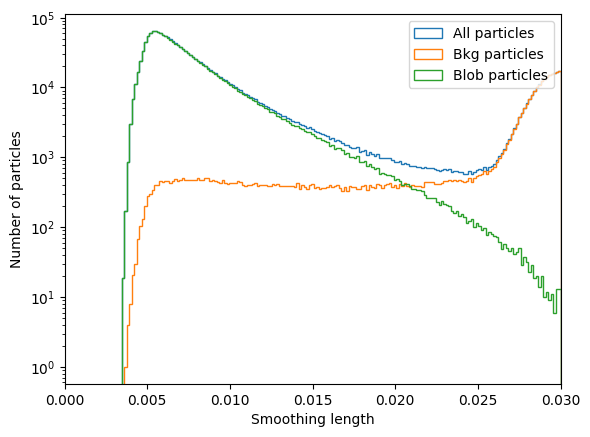

In [66]:
plt.hist(hpart, bins=np.linspace(0,0.03, 200), log=True, histtype='step', label='All particles'); plt.xlim([0,0.03])
plt.hist(hpart[0:len(hpart)//4], bins=np.linspace(0,0.03, 200), log=True, histtype='step', label='Bkg particles'); plt.xlim([0,0.03])
plt.hist(hpart[len(hpart)//4:], bins=np.linspace(0,0.03, 200), log=True, histtype='step', label='Blob particles'); plt.xlim([0,0.03])
plt.legend()
plt.xlabel('Smoothing length')
plt.ylabel('Number of particles')
